In [1]:
import numpy as np
import os
import csv, datetime
#from scipy.interpolate import interp1d
#from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
# voy al direcotrio desde donde voy a trabajar
os.chdir('/home/ludeu/Escritorio/MachineLearning/Data/proyecto/power-consumption')

#creo mi path
archivo = os.path.join("..", "power-consumption","powerconsumption.csv")

#leo el archivo y guardon en data
with open(archivo,"r") as fp:
    reader = csv.reader(fp, delimiter=",")
    data = []
    for row in reader:
        data.append(row)

data = data[1:]

#creo un diccionario para manipular mejor mi archivo
data_dicc = {'TIME': [],
             'TEMP': [],
             'HUM': [],
             'VEL_VIENTO': [],
             'DIFU_GENERAL': [],
             'DIFU': [],
             'CONSUM_ZONA1': [],
             'CONSUM_ZONA2': [],
             'CONSUM_ZONA3': []
             }

cont_menos_datos = 0

for fila in data:
    if len(fila) > 8:
        data_dicc['TIME'].append(datetime.datetime.strptime(fila[0],'%m/%d/%Y %H:%M'))
        data_dicc['TEMP'].append(float(fila[1]))
        data_dicc['HUM'].append(float(fila[2]))
        data_dicc['VEL_VIENTO'].append(float(fila[3]))
        data_dicc['DIFU_GENERAL'].append(float(fila[4]))
        data_dicc['DIFU'].append(float(fila[5]))
        data_dicc['CONSUM_ZONA1'].append(float(fila[6]))
        data_dicc['CONSUM_ZONA2'].append(float(fila[7]))
        data_dicc['CONSUM_ZONA3'].append(float(fila[8]))
    else:
        cont_menos_datos += 1 

# como vemos por cont_menos_datos no hay casillas vacias

#convierto los datos en un array y el tiempo en otro

claves = [clave for clave in data_dicc if clave != 'TIME']

arrays_columnas = [np.array(data_dicc[clave]) for clave in claves]

datos = np.column_stack(arrays_columnas)
time = data_dicc['TIME']


In [3]:
datos[1,:]
datos.shape

(52416, 8)

In [4]:
#verificamos que estes equiespaciados:
from collections import Counter
espaciado = [time[i+1]-time[i] for i in range(len(time)-1)]

Counter(espaciado)
#estan espaciados todos po 10min

Counter({datetime.timedelta(seconds=600): 52415})

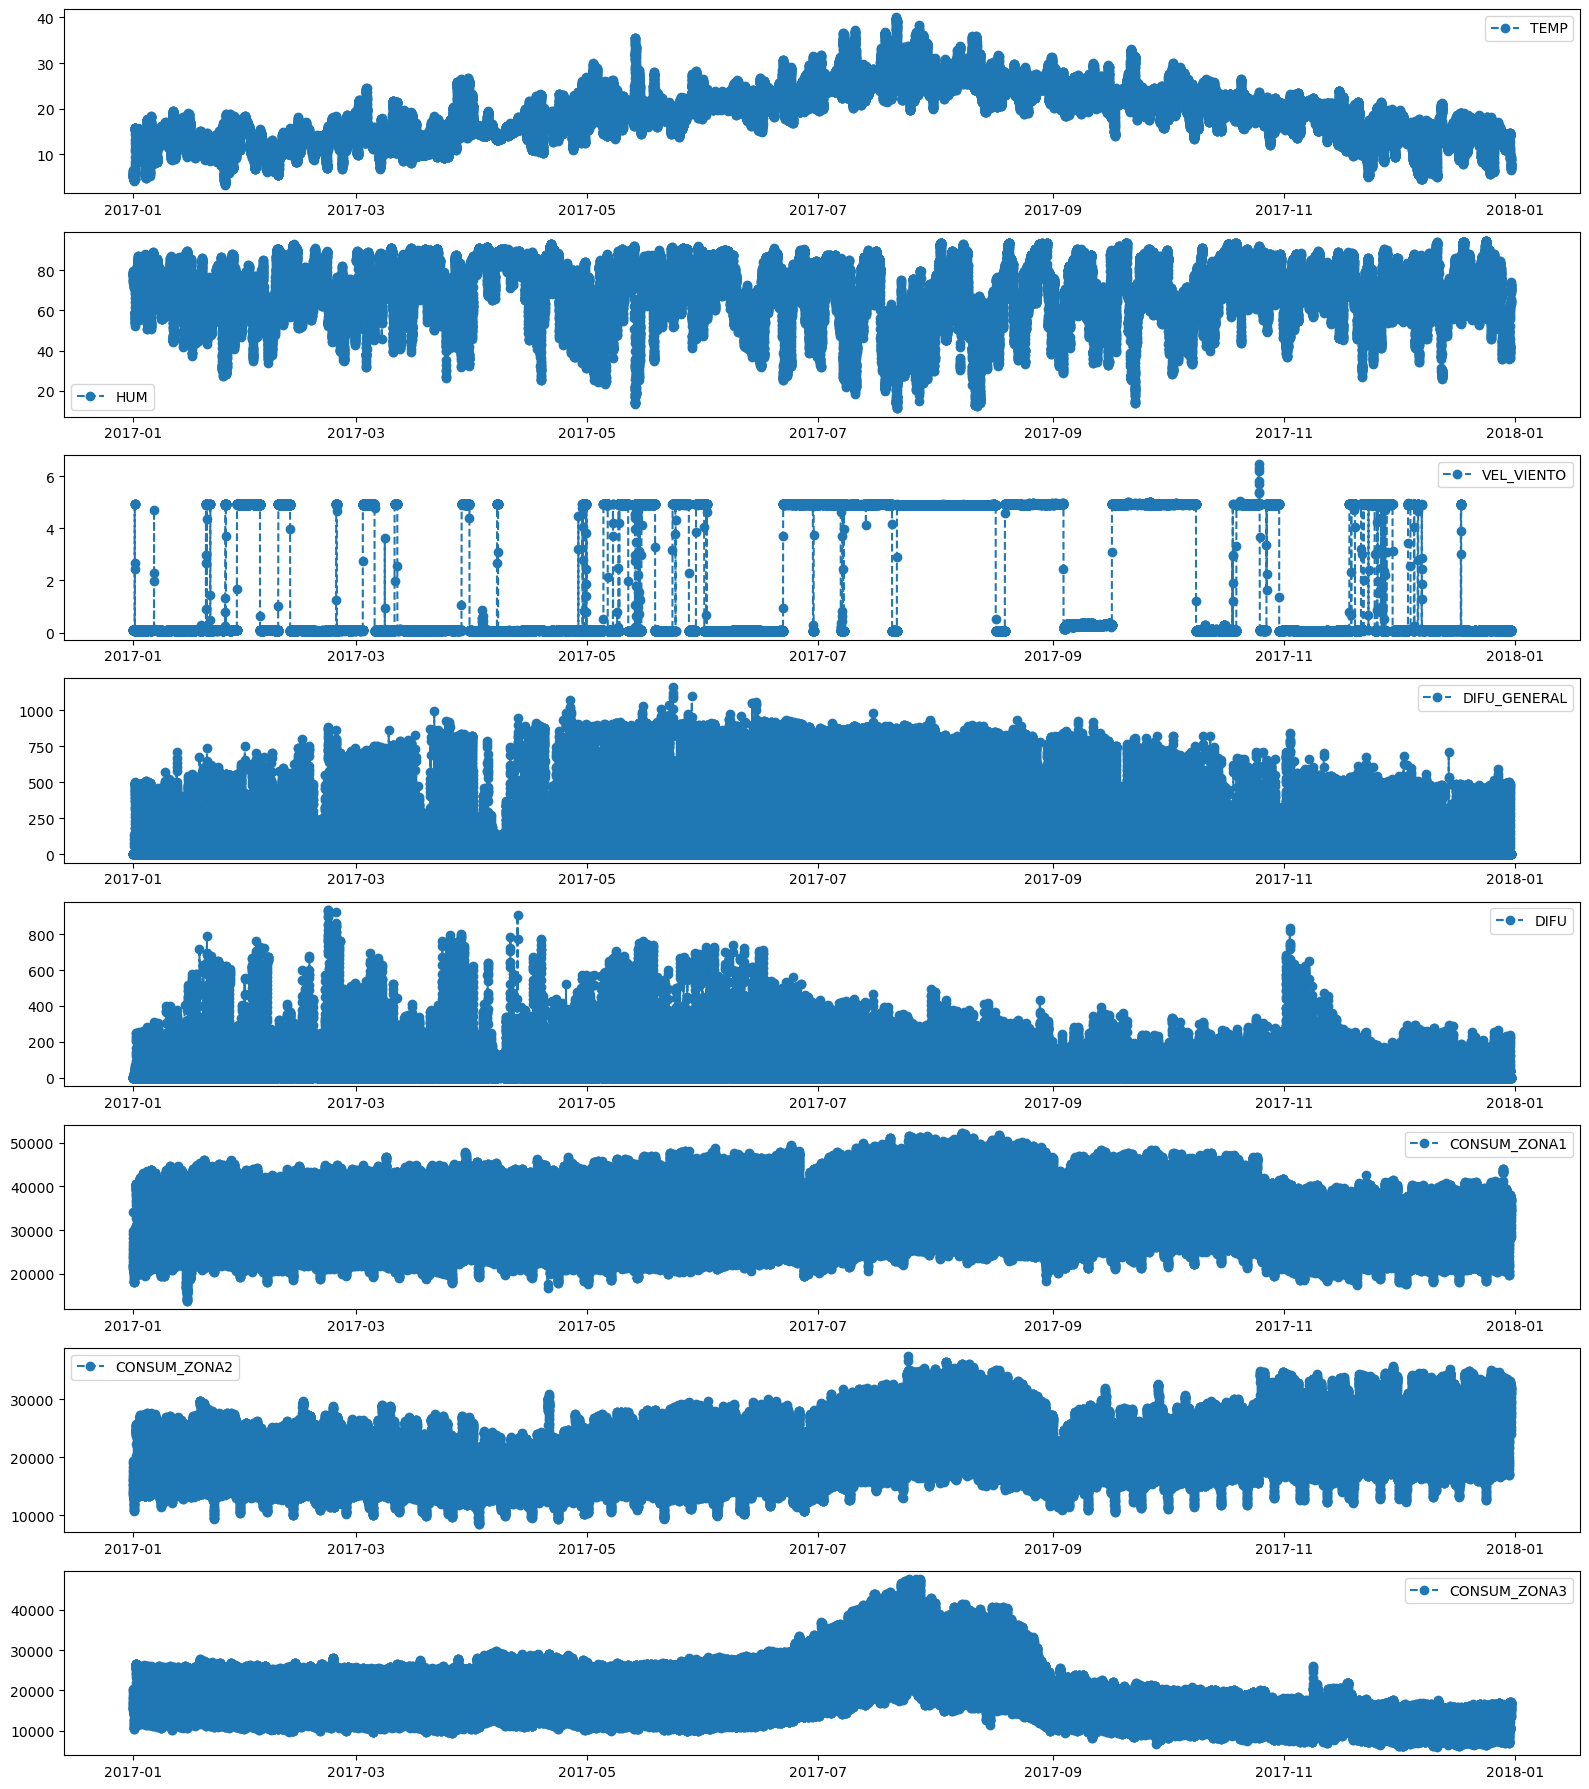

In [5]:
#graficamos datos crudos

fig, axs = plt.subplots(datos.shape[1],1, figsize=(16,18))
for i in range(datos.shape[1]):
    axs[i].plot(time, datos[:,i],'o--', label=claves[i])
    axs[i].legend()
fig.tight_layout()


In [6]:
time_arr = np.array(time)
time_arr[:144*6:144].astype(str)

array(['2017-01-01 00:00:00', '2017-01-02 00:00:00',
       '2017-01-03 00:00:00', '2017-01-04 00:00:00',
       '2017-01-05 00:00:00', '2017-01-06 00:00:00'], dtype='<U19')

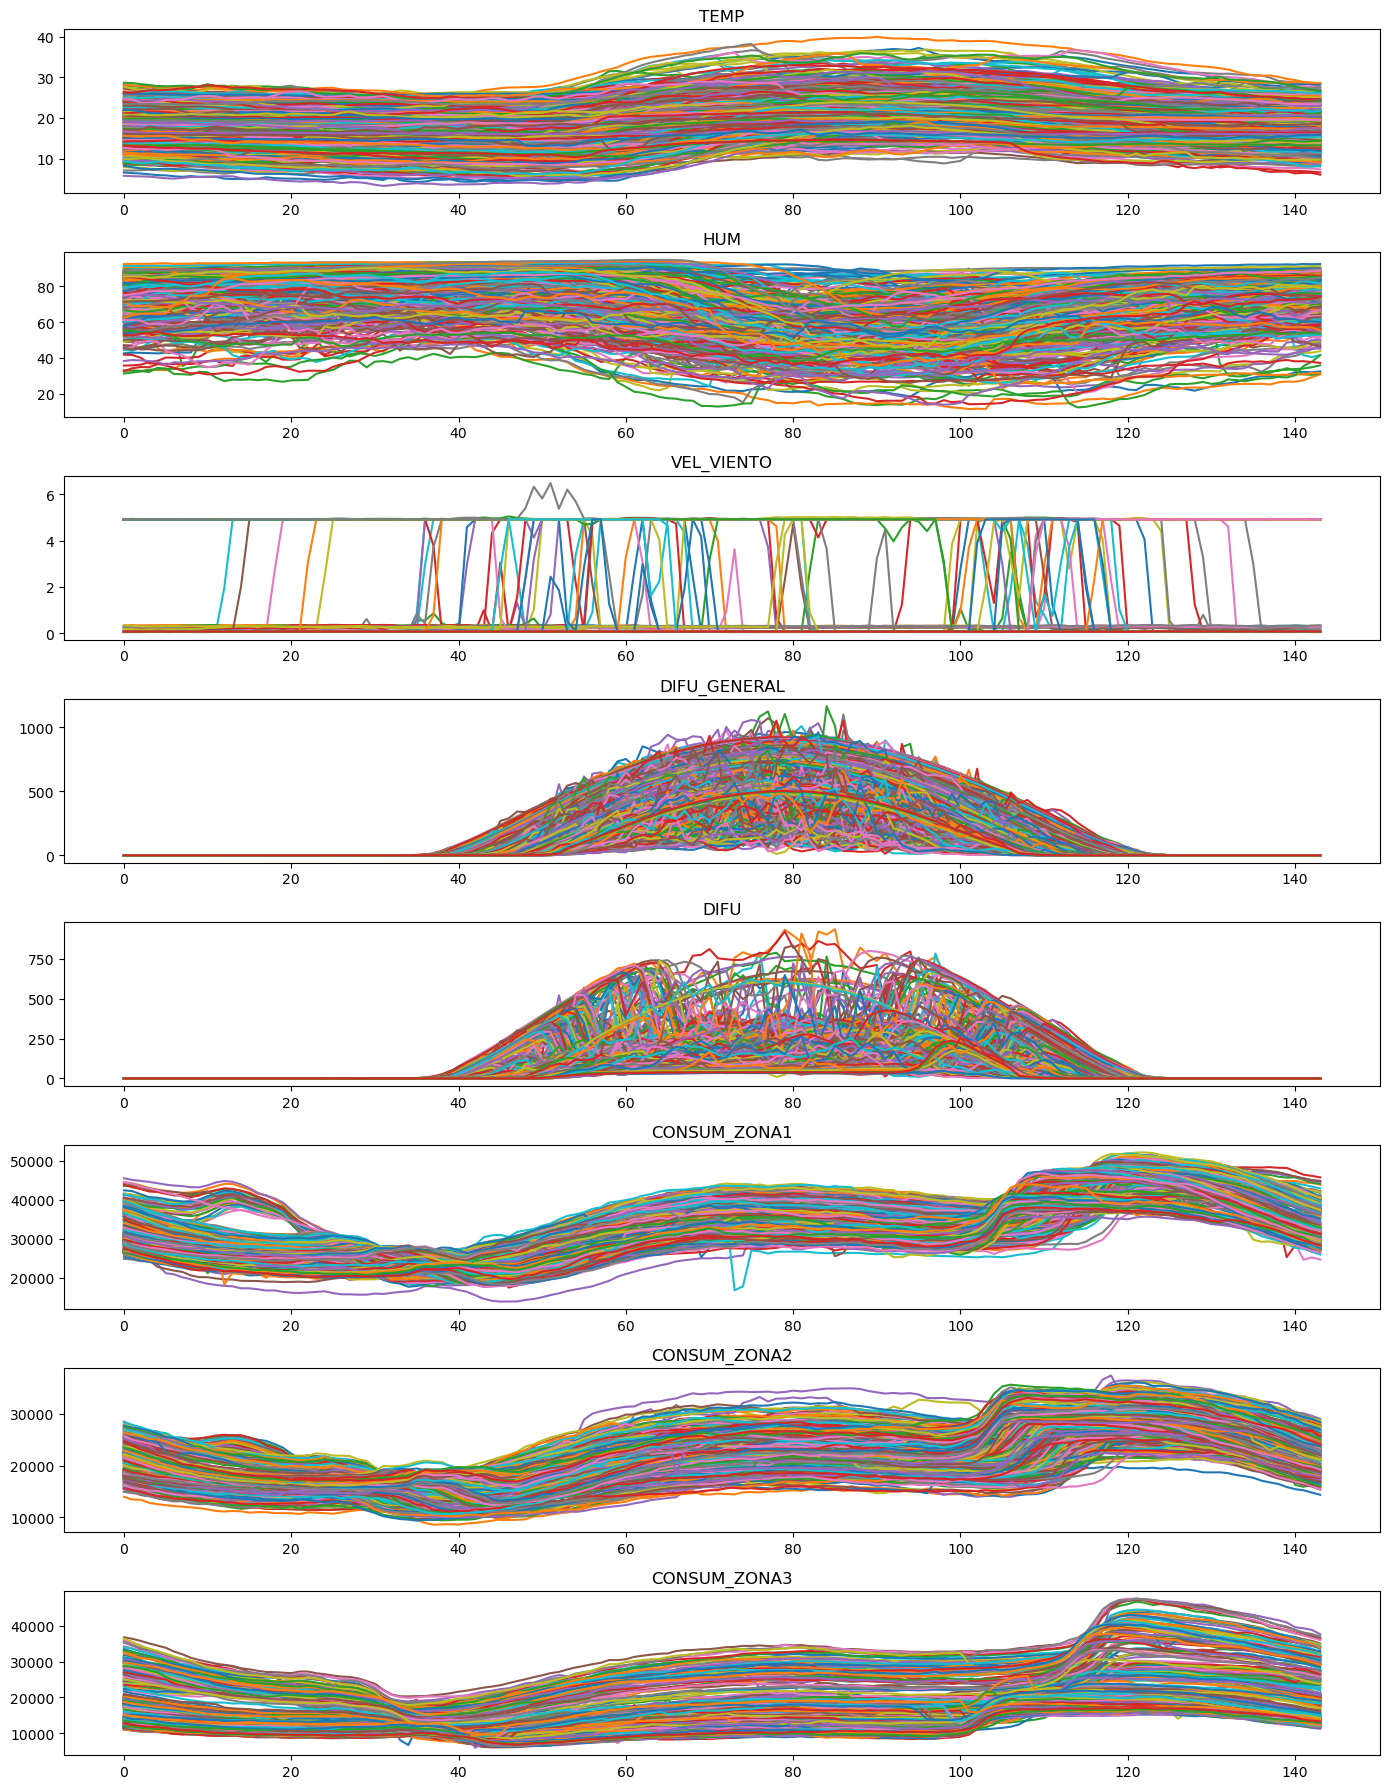

In [7]:
# graficamos datos cada 24 hs:

fig, axs = plt.subplots(8,1, figsize=(14,18))

for i in range(8):
    for j in range(len(time_arr)//144):
        axs[i].plot(datos[j*144:(j+1)*144,i], '-')
    axs[i].set_title(claves[i])
fig.tight_layout()

In [8]:
60*24*30/10
time_arr[::4320].astype(str)

array(['2017-01-01 00:00:00', '2017-01-31 00:00:00',
       '2017-03-02 00:00:00', '2017-04-01 00:00:00',
       '2017-05-01 00:00:00', '2017-05-31 00:00:00',
       '2017-06-30 00:00:00', '2017-07-30 00:00:00',
       '2017-08-29 00:00:00', '2017-09-28 00:00:00',
       '2017-10-28 00:00:00', '2017-11-27 00:00:00',
       '2017-12-27 00:00:00'], dtype='<U19')

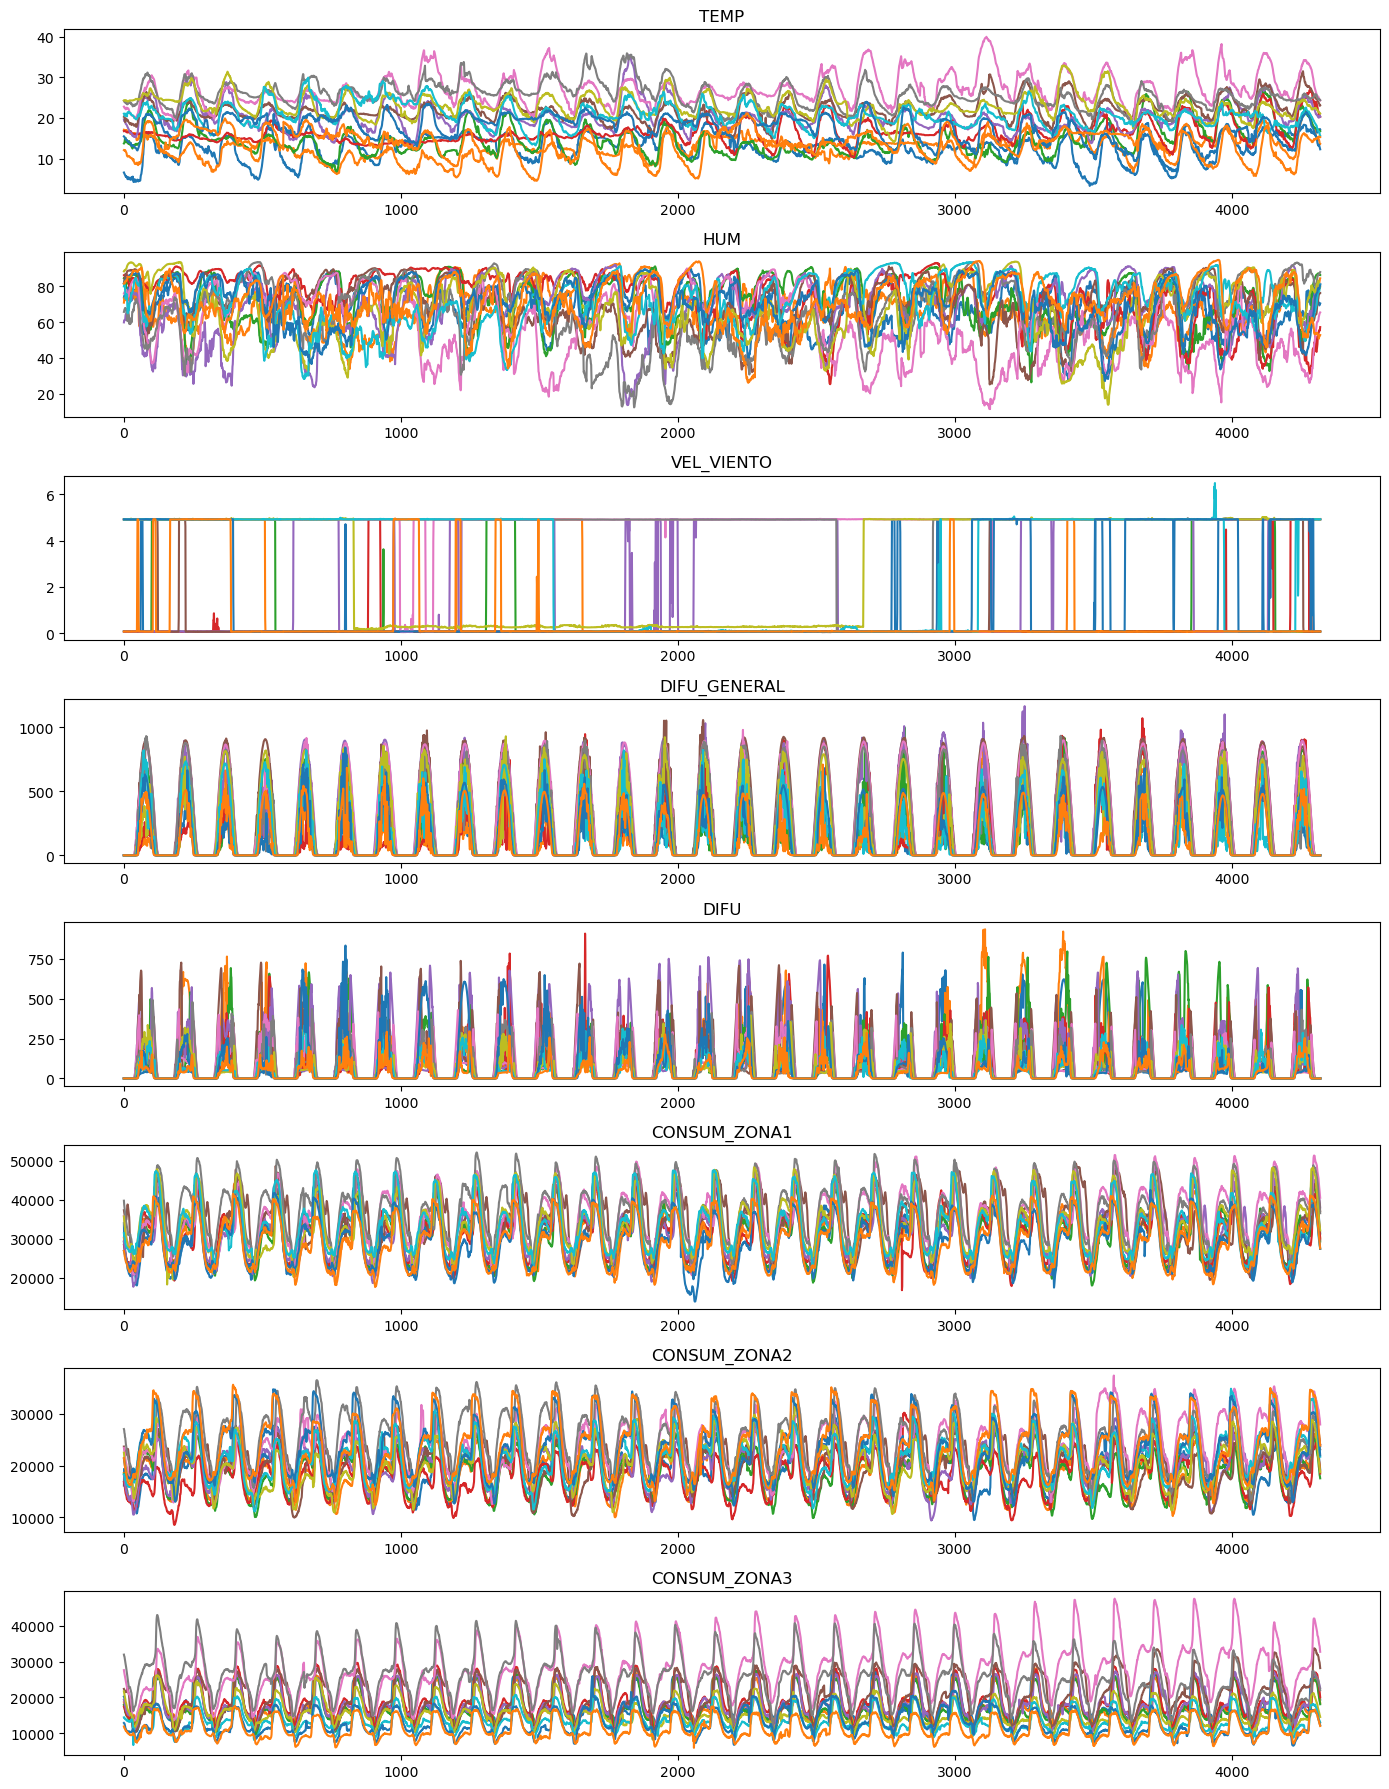

In [9]:
# graficamos datos cada mes:

fig, axs = plt.subplots(8,1, figsize=(14,18))

for i in range(8):
    for j in range(len(time_arr)//4320):
        axs[i].plot(datos[j*4320:(j+1)*4320,i], '-')
    axs[i].set_title(claves[i])
fig.tight_layout()

In [ ]:
#con estos analisis podemos la mayoria de las variables son estacionarios y podemos calcular alguna relacion entre ellos

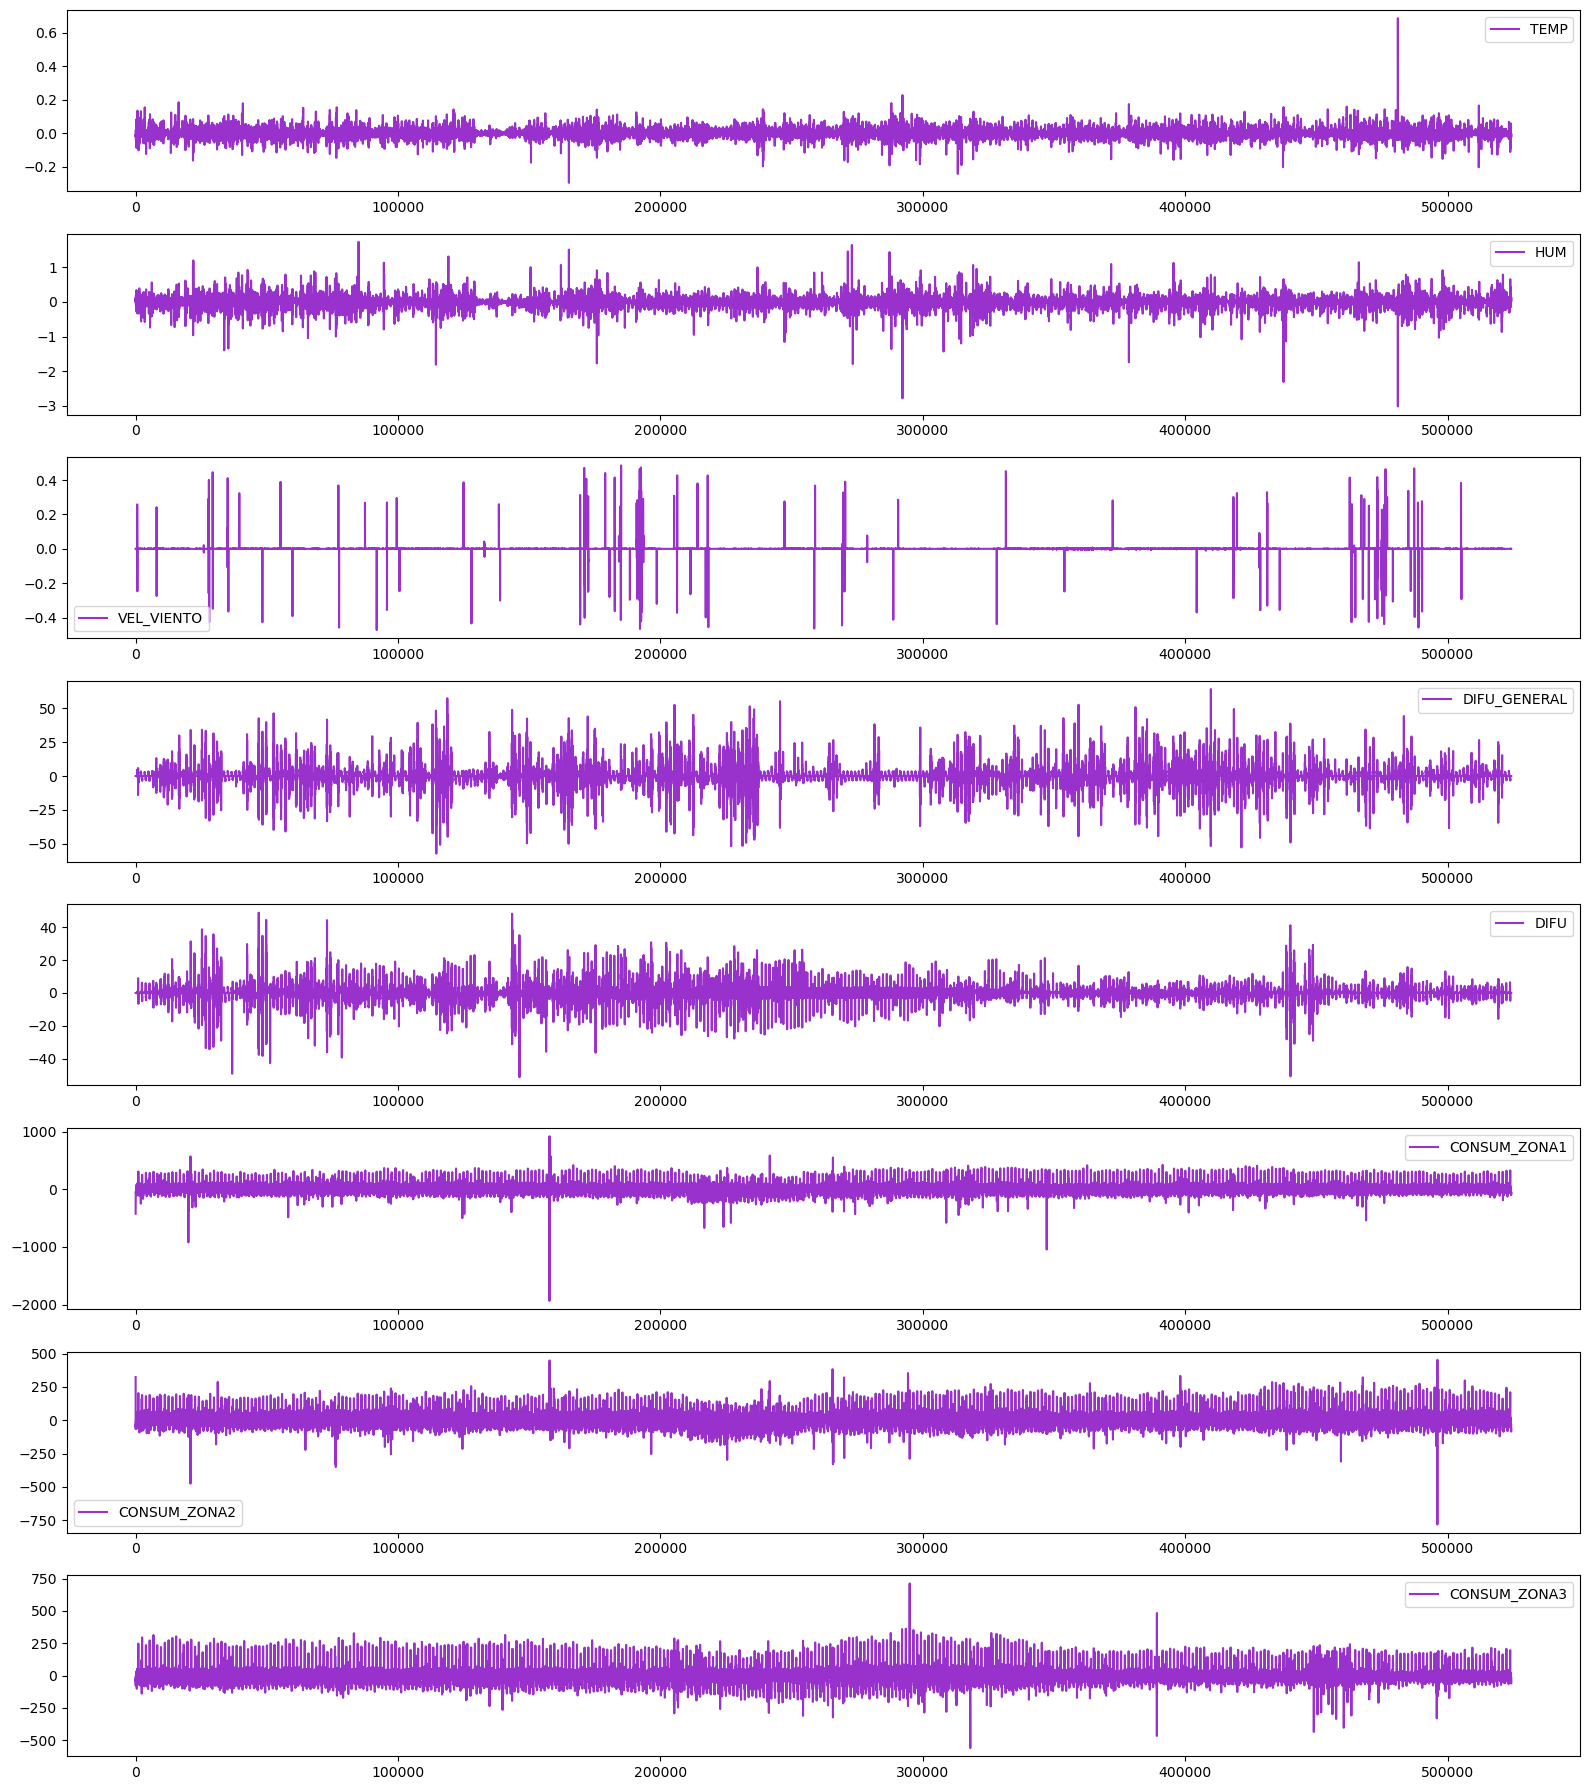

In [10]:
# analisis de cambios locales (derivadas)
def dif_fin(x,t):
    assert len(x) == len(t) , "las listas deben tener el mismo tamaño" 
    tam = len(x)
    x_d = (x[1:tam]-x[:tam-1])/(t[1:tam]-t[:tam-1])
    return x_d

#la definicion necesita dos listas o arrays, creo una lista con los tiempos en minutos, como sabes que estan
# espaciados por 10 minutos, creamos un array:

time2 = np.arange(0,524160,10)

#creamos la derivada y graficamos:

fig, axs = plt.subplots(datos.shape[1],1, figsize=(16,18))
for i in range(datos.shape[1]):
    axs[i].plot(time2[1:], dif_fin(datos[:,i],time2), '-', label=claves[i], color="darkorchid")
    axs[i].legend()
fig.tight_layout()


$$ Sm[X(t_i)] = \sum_{r=-q}^{s} {a_r X(t_{i+r})} $$

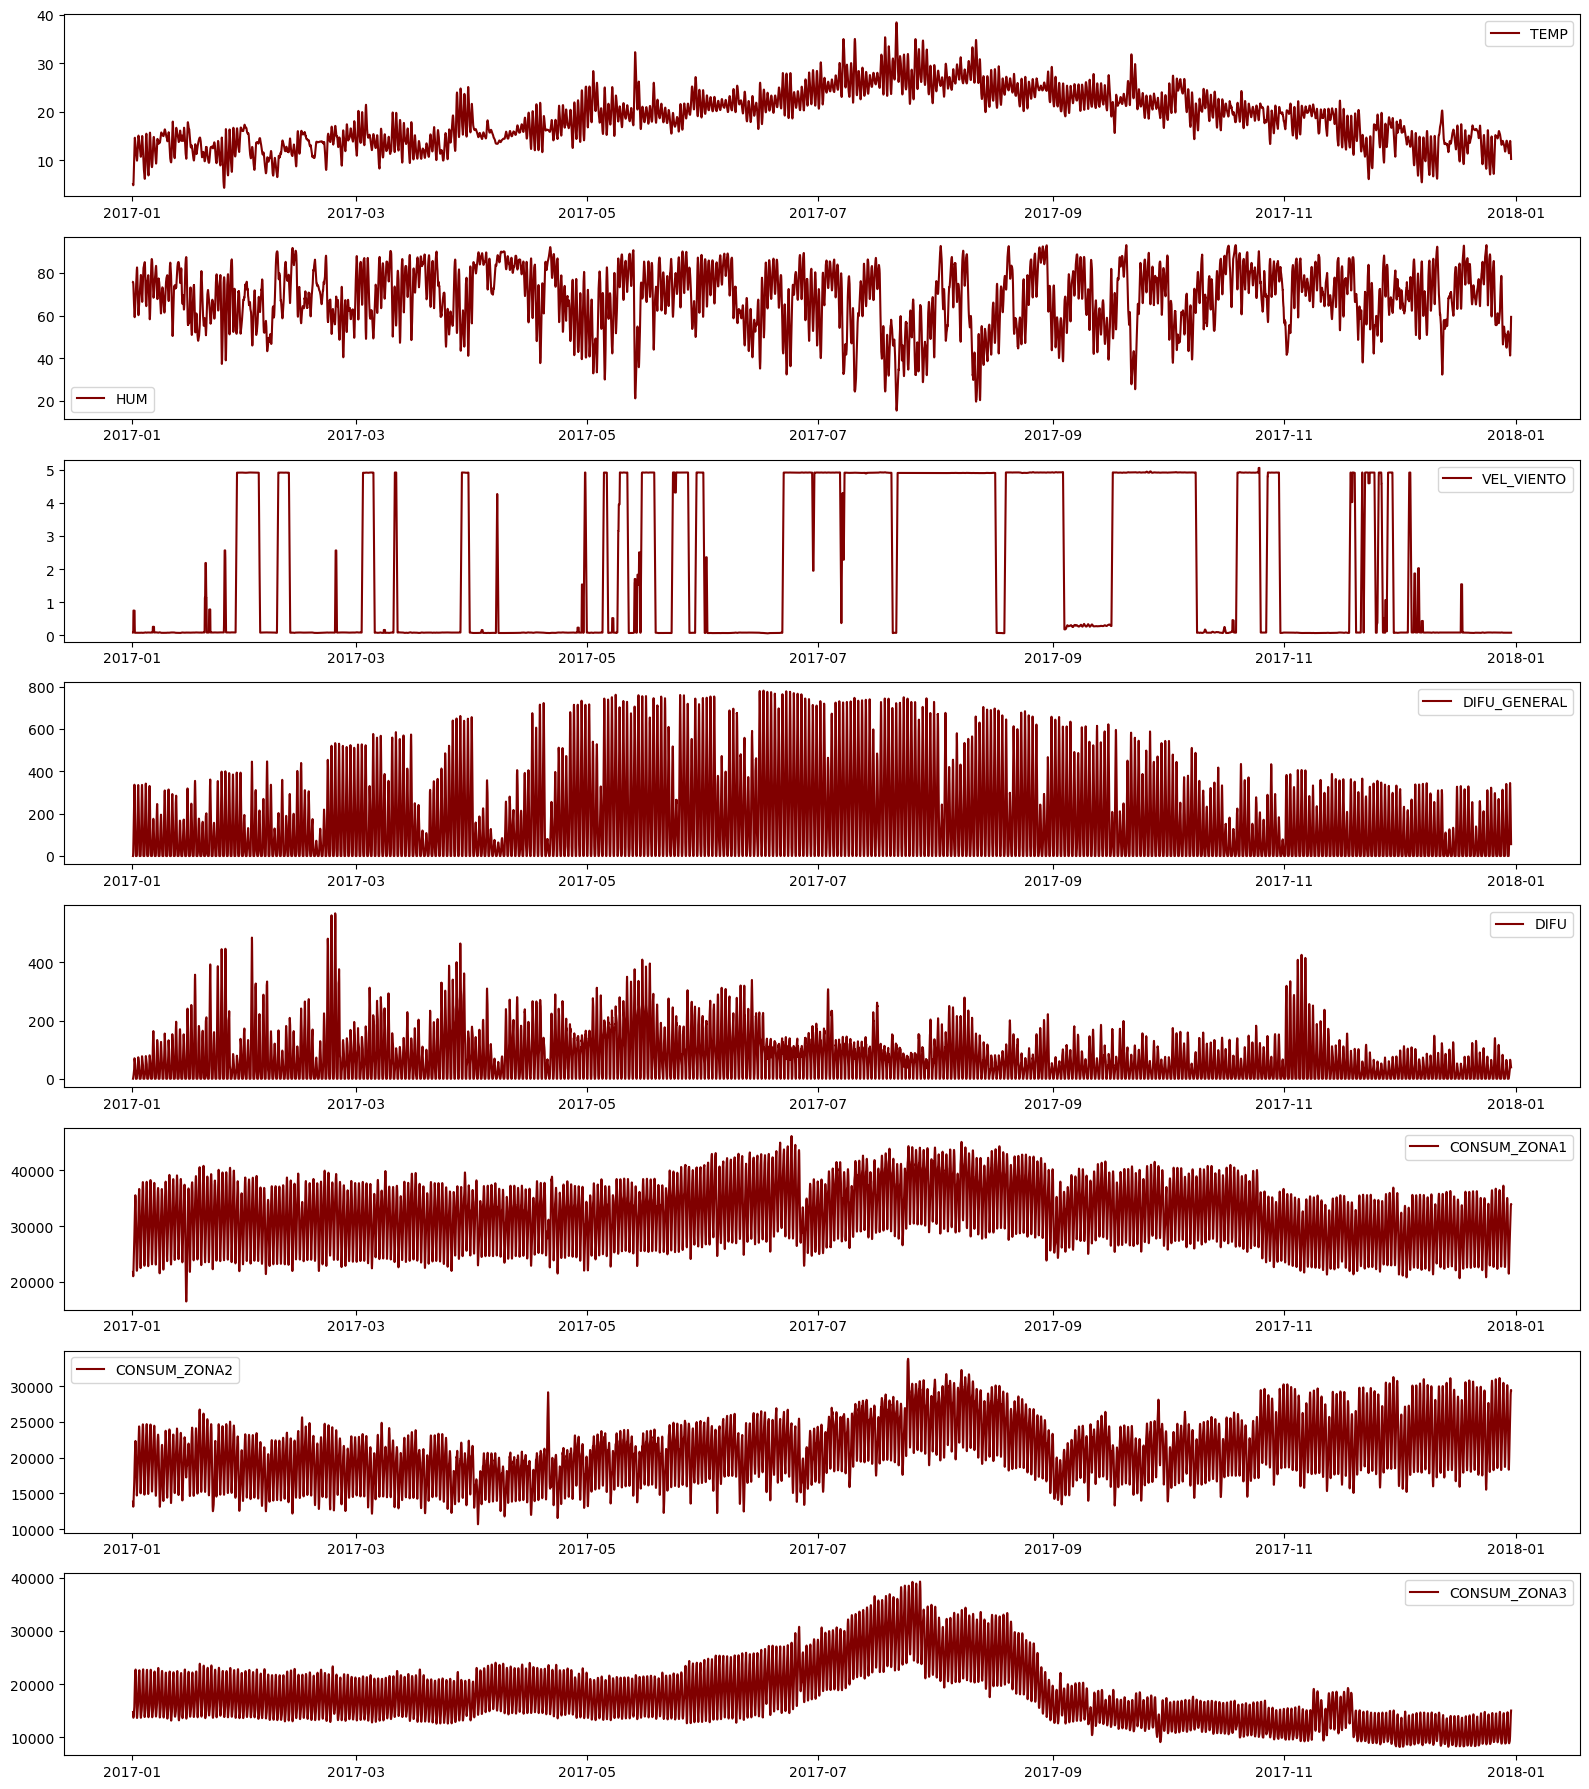

In [11]:
#analisis de media movil
def med_mov(t, x, paso):
    assert paso%2 == 1, 'el paso debe ser debe ser entero e impar' 
    n_saltos = x.shape[0]
    n_ventanas = n_saltos-paso
    tstamps = []
    y = np.zeros(n_ventanas)
    for i in range(0, n_ventanas):
        derch = n_saltos - i 
        izq = n_saltos - i - paso 
        y[n_ventanas - i - 1] = x[izq:derch].mean() 
        tstamps.insert(0,t[(izq+derch)//2])
    return tstamps, y

#graficamos las medias moviles cambiando ventanas

ws=51

fig, axs = plt.subplots(datos.shape[1],1, figsize=(16,18))
for i in range(datos.shape[1]):
    t, x = med_mov(time, datos[:,i], ws)
    axs[i].plot(t, x, '-', label=claves[i], color="maroon")
    axs[i].legend()
fig.tight_layout()


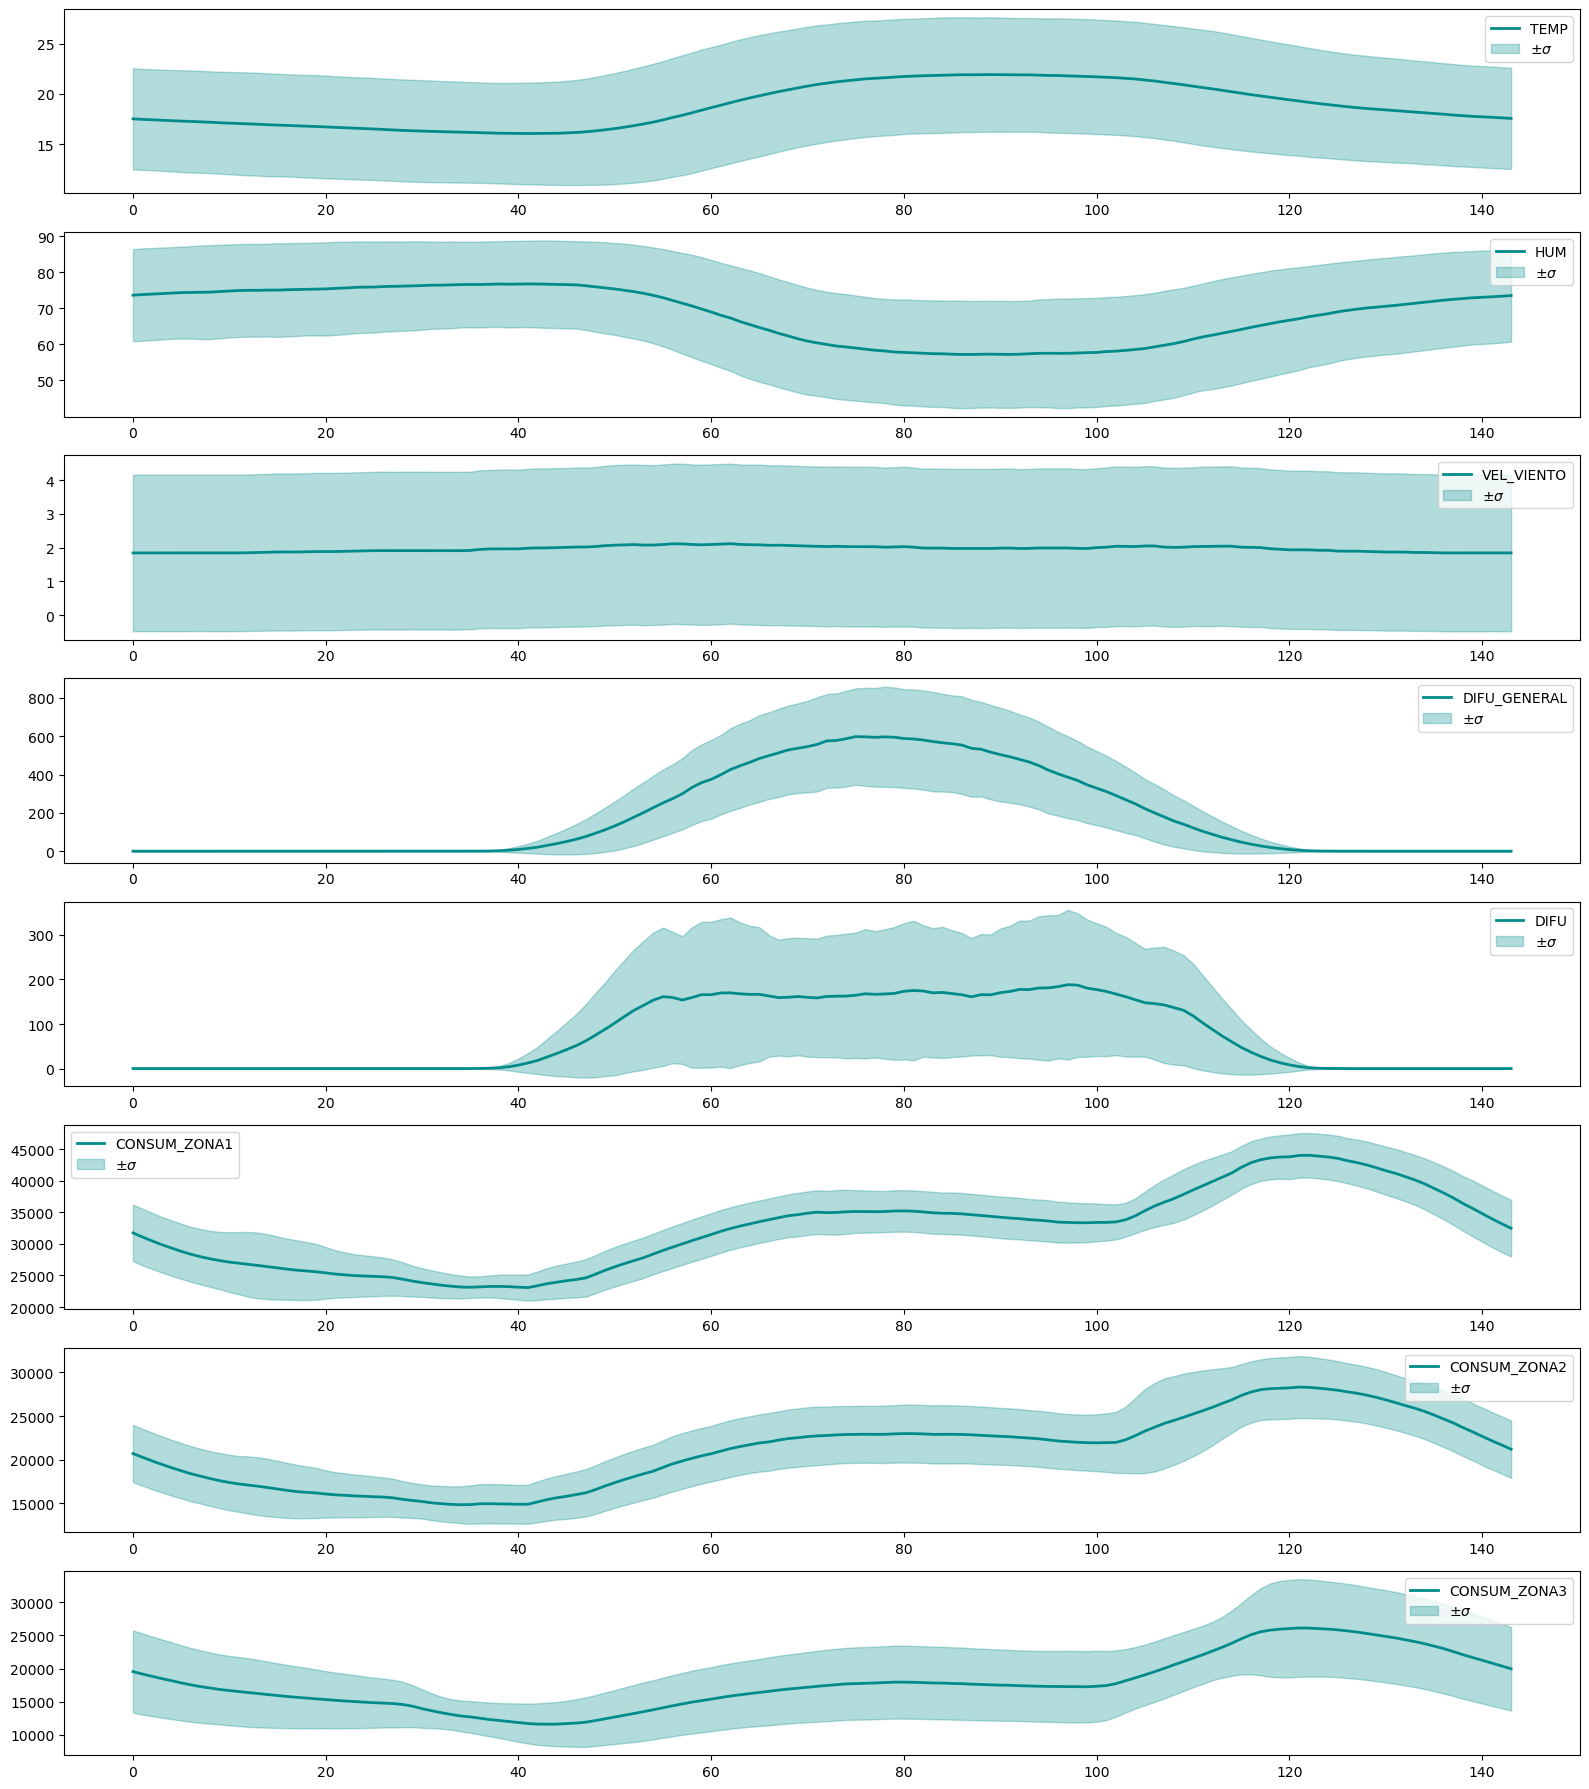

In [17]:
#analizamos la media y la desviacion estandar cada 10 minutos durante 24 hs en el año:
# calculamos la media y la desviacion estandar para cada hora sobre los 30 días
#para esto vamos a crear un array con filas de 24hs en pasos de 10 min, columnas la cantidad de dias en un año
# y eso para cada variable en el mismo array

arr_datos = []
for i in range(144):
    arr_datos.append(datos[i::144])
dias_datos = np.array(arr_datos)
#print(arr_datos.shape)

dias_media = dias_datos.mean(axis=1)
dias_std = dias_datos.std(axis=1)

# graficamos la media con su desviacion

fig, axs = plt.subplots(8,1, figsize=(16,18))
for i in range(len(claves)):
    axs[i].plot(dias_media[:,i], label=claves[i], lw = 2, color="darkcyan")
    abajo = dias_media[:,i] - dias_std[:,i]
    arriba = dias_media[:,i] + dias_std[:,i]
    axs[i].fill_between(np.arange(144), abajo, arriba, label='$\pm \sigma$', alpha = 0.3, color="darkcyan")
    axs[i].legend()
fig.tight_layout()


52416